# Brief for nuclear mass and binding energy

A basic quantity which can be measured for the ground states of nuclei is the atomic mass $M(N,Z)$ of the neutral atom with atomic mass number $A$ and charge $Z$. The number of neutrons is $N$. There are indeed several sophisticated experiments worldwide which allow us to measure this quantity to high precision (parts per million even).

Atomic masses are usually tabulated in terms of the mass excess defined by

$$\Delta M(N,Z)=M(N,Z)-\mu A$$

The nuclear binding energy is defined as the energy required to break up a given nucleus into its constituent parts of $N$ neutrons and $Z$ protons. In terms of the atomic masses $M(N,Z)$ the binding energy is defined by

$$BE(N,Z)=ZM_{H}c^2+Nm_{n}c^2-M(N,Z)c^2$$

where $M_{H}$ is the mass of hydrogen atom and $m_{h}$ is the mass of the neutron. In terms of the mass execss the binding energy is given by 

$$BE(N,Z)=Z\Delta_{H}c^2+N\Delta_{n}c^2-\Delta(N,Z)c^2$$

A popular and physically intuitive model which can be used to parametrize the experimental binding energies as function of $A$, is the so-called liquid drop model. The ansatz is based on the following expression

$$BE(N,Z)=a_{1}A-a_{2}A^{2/3}-a_{3}\frac{Z^2}{A^{1/3}}-a_{4}\frac{(N-Z)^2}{A}$$

where $A$ stands for the number of nucleons and $a_{i}$ are parameters which determined by a fit to the experimental data. 

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.linear_model as skl
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import os

# Where to save the figures and data files
PROJECT_ROOT_DIR = "Results"
FIGURE_ID = "Results/FigureFiles"
DATA_ID = "DataFiles/"

if not os.path.exists(PROJECT_ROOT_DIR):
    os.mkdir(PROJECT_ROOT_DIR)

if not os.path.exists(FIGURE_ID):
    os.makedirs(FIGURE_ID)

if not os.path.exists(DATA_ID):
    os.makedirs(DATA_ID)

def image_path(fig_id):
    return os.path.join(FIGURE_ID, fig_id)

def data_path(dat_id):
    return os.path.join(DATA_ID, dat_id)

def save_fig(fig_id):
    plt.savefig(image_path(fig_id) + ".png", format='png')

infile = open(data_path("MassEval2016.dat"),'r')

# Read the experimental data with Pandas
Masses = pd.read_fwf(infile, usecols=(2,3,4,6,11),
              names=('N', 'Z', 'A', 'Element', 'Ebinding'),
              widths=(1,3,5,5,5,1,3,4,1,13,11,11,9,1,2,11,9,1,3,1,12,11,1),
              header=39,
              index_col=False)

# Extrapolated values are indicated by '#' in place of the decimal place, so
# the Ebinding column won't be numeric. Coerce to float and drop these entries.
Masses['Ebinding'] = pd.to_numeric(Masses['Ebinding'], errors='coerce')
Masses = Masses.dropna()
# Convert from keV to MeV.
Masses['Ebinding'] /= 1000

# Group the DataFrame by nucleon number, A.
Masses = Masses.groupby('A')
# Find the rows of the grouped DataFrame with the maximum binding energy.
Masses = Masses.apply(lambda t: t[t.Ebinding==t.Ebinding.max()])

A = Masses['A']
Z = Masses['Z']
N = Masses['N']
Element = Masses['Element']
Energies = Masses['Ebinding']
#print(Masses)

X = np.zeros((len(A),5))
X[:,0] = 1
X[:,1] = A
X[:,2] = A**(2.0/3.0)
X[:,3] = A**(-1.0/3.0)
X[:,4] = A**(-1.0)

# Then nice printout using pandas
DesignMatrix = pd.DataFrame(X)
DesignMatrix.index = A
DesignMatrix.columns = ['1', 'A', 'A^(2/3)', 'A^(-1/3)', '1/A']
display(DesignMatrix)

,1,A,A^(2/3),A^(-1/3),1/A
A,,,,,
4,1.0,4.0,2.519842,0.629961,0.250000
5,1.0,5.0,2.924018,0.584804,0.200000
6,1.0,6.0,3.301927,0.550321,0.166667
7,1.0,7.0,3.659306,0.522758,0.142857
8,1.0,8.0,4.000000,0.500000,0.125000
...,...,...,...,...,...
264,1.0,264.0,41.153106,0.155883,0.003788
265,1.0,265.0,41.256962,0.155687,0.003774
266,1.0,266.0,41.360688,0.155491,0.003759


## Ordinary Least Squares

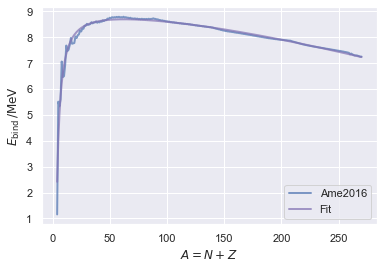

In [15]:
# matrix inversion to find beta
# beta = np.linalg.inv(X.T @ X) @ X.T @ Energies
# # or in a more old-fashioned way
# # beta = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(Energies)
# # and then make the prediction
# ytilde = X @ beta

# the least squares functionality in Numpy as

fit = np.linalg.lstsq(X, Energies, rcond =None)[0]
ytildenp = np.dot(fit,X.T)

Masses['Eapprox']  = ytilde
# Generate a plot comparing the experimental with the fitted values values.
fig, ax = plt.subplots()
ax.set_xlabel(r'$A = N + Z$')
ax.set_ylabel(r'$E_\mathrm{bind}\,/\mathrm{MeV}$')
ax.plot(Masses['A'], Masses['Ebinding'], alpha=0.7, lw=2,
            label='Ame2016')
ax.plot(Masses['A'], Masses['Eapprox'], alpha=0.7, lw=2, c='m',
            label='Fit')
ax.legend()
save_fig("Masses2016OLS")
plt.show()


## Adding error analysis and training set up
We can easily test our fit by computing the $R2$ score that we discussed in connection with the functionality of _Scikit_Learn_ in the introductory slides. Since we are not using _Scikit-Learn_ here we can define our own $R2$ function as

In [20]:
def R2(y_data,y_model):
    return 1-np.sum((y_data-y_model)**2)/np.sum((y_data-np.mean(y_data))**2)

print(R2(Energies,ytilde))

#MSE

def MSE(y_data,y_model):
    n = np.size(y_model)
    return np.sum((y_data-y_model)**2)/n

print(MSE(Energies,ytilde))

# relative error

def RelativeError(y_data,y_model):
    return abs((y_data-y_model)/y_data)

print(RelativeError(Energies,ytilde))

0.9549351910143222
0.022022882954618364
A        
4    0       1.093247
5    2       0.275341
6    7       0.060080
7    12      0.019587
8    17      0.117986
               ...   
264  3297    0.000148
265  3303    0.001263
266  3310    0.002948
269  3331    0.000599
270  3337    0.002526
Name: Ebinding, Length: 264, dtype: float64


In [ ]:



clf = skl.LinearRegression().fit(X, Energies)
fity = clf.predict(X)

# The mean squared error                               
print("Mean squared error: %.2f" % mean_squared_error(Energies, fity))
# Explained variance score: 1 is perfect prediction                                 
print('Variance score: %.2f' % r2_score(Energies, fity))
# Mean absolute error                                                           
print('Mean absolute error: %.2f' % mean_absolute_error(Energies, fity))
print(clf.coef_, clf.intercept_)

Masses['Eapprox']  = fity
# Generate a plot comparing the experimental with the fitted values values.
fig, ax = plt.subplots()
ax.set_xlabel(r'$A = N + Z$')
ax.set_ylabel(r'$E_\mathrm{bind}\,/\mathrm{MeV}$')
ax.plot(Masses['A'], Masses['Ebinding'], alpha=0.7, lw=2,
            label='Ame2016')
ax.plot(Masses['A'], Masses['Eapprox'], alpha=0.7, lw=2, c='m',
            label='Fit')
ax.legend()
save_fig("Masses2016")
plt.show()

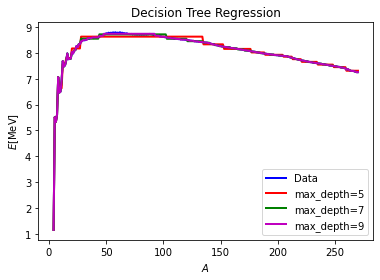

            N    Z    A Element  Ebinding   Eapprox
A                                                  
4   0       1    3    4      Li  1.153760  1.153760
5   2       3    2    5      He  5.512132  5.512132
6   7       3    3    6      Li  5.332331  5.332331
7   12      4    3    7      Li  5.606439  5.606439
8   17      4    4    8      Be  7.062435  7.062435
...       ...  ...  ...     ...       ...       ...
264 3297  156  108  264      Hs  7.298375  7.298375
265 3303  157  108  265      Hs  7.296247  7.296247
266 3310  158  108  266      Hs  7.298273  7.298273
269 3331  159  110  269      Ds  7.250154  7.250154
270 3337  160  110  270      Ds  7.253775  7.253775

[264 rows x 6 columns]
0.00701240361399725


In [4]:
#Decision Tree Regression
from sklearn.tree import DecisionTreeRegressor
regr_1=DecisionTreeRegressor(max_depth=5)
regr_2=DecisionTreeRegressor(max_depth=7)
regr_3=DecisionTreeRegressor(max_depth=9)
regr_1.fit(X, Energies)
regr_2.fit(X, Energies)
regr_3.fit(X, Energies)


y_1 = regr_1.predict(X)
y_2 = regr_2.predict(X)
y_3=regr_3.predict(X)
Masses['Eapprox'] = y_3
# Plot the results
plt.figure()
plt.plot(A, Energies, color="blue", label="Data", linewidth=2)
plt.plot(A, y_1, color="red", label="max_depth=5", linewidth=2)
plt.plot(A, y_2, color="green", label="max_depth=7", linewidth=2)
plt.plot(A, y_3, color="m", label="max_depth=9", linewidth=2)

plt.xlabel("$A$")
plt.ylabel("$E$[MeV]")
plt.title("Decision Tree Regression")
plt.legend()
save_fig("Masses2016Trees")
plt.show()
print(Masses)
print(np.mean( (Energies-y_1)**2))

/Users/yinu/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/yinu/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/yinu/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/yinu/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged 

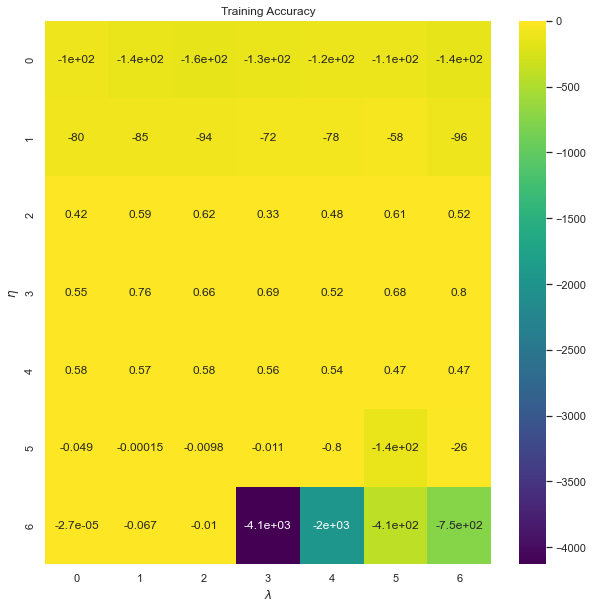

In [5]:
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import accuracy_score
import seaborn as sns

X_train = X
Y_train = Energies
n_hidden_neurons = 100
epochs = 100
# store models for later use
eta_vals = np.logspace(-5, 1, 7)
lmbd_vals = np.logspace(-5, 1, 7)
# store the models for later use
DNN_scikit = np.zeros((len(eta_vals), len(lmbd_vals)), dtype=object)
train_accuracy = np.zeros((len(eta_vals), len(lmbd_vals)))
sns.set()
for i, eta in enumerate(eta_vals):
    for j, lmbd in enumerate(lmbd_vals):
        dnn = MLPRegressor(hidden_layer_sizes=(n_hidden_neurons), activation='logistic',
                            alpha=lmbd, learning_rate_init=eta, max_iter=epochs)
        dnn.fit(X_train, Y_train)
        DNN_scikit[i][j] = dnn
        train_accuracy[i][j] = dnn.score(X_train, Y_train)

fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(train_accuracy, annot=True, ax=ax, cmap="viridis")
ax.set_title("Training Accuracy")
ax.set_ylabel("$\eta$")
ax.set_xlabel("$\lambda$")
plt.show()
